In [14]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
!pip install sklearn
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
import matplotlib.pylab as plt

In [15]:
original_data = pd.read_csv(
    "./data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python')
original_data.head()


,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [16]:
print('## 1.4. Missing values')
for i,j in zip(original_data.columns,(original_data.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        print(str(i) + ': ' + str(j) + ' records')

## 1.4. Missing values
Workclass: 1836 records
Occupation: 1843 records
Country: 583 records


(32561, 15)


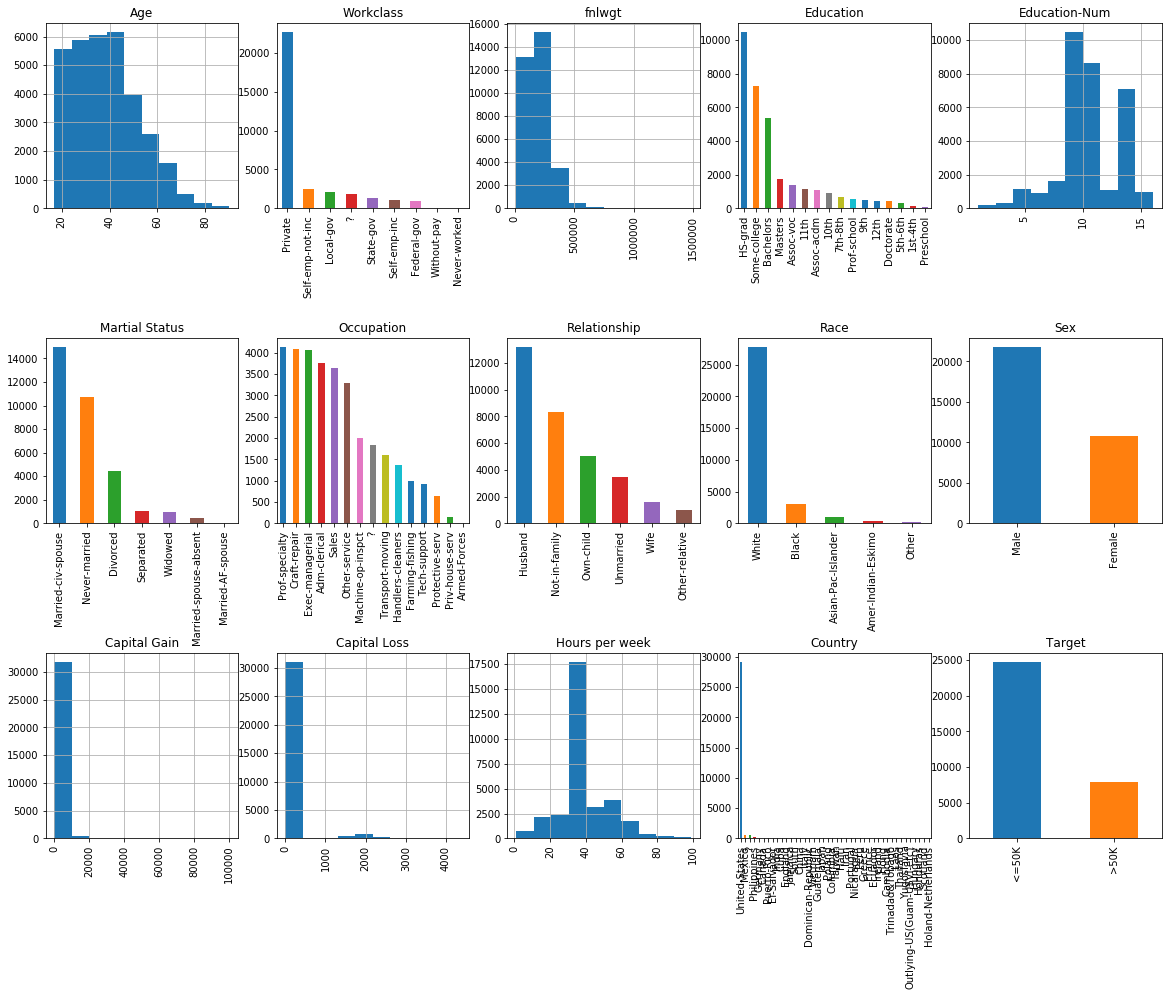

In [17]:
fig = plt.figure(figsize=(20,15))
cols = 5
print(original_data.shape)
rows = np.ceil(float(original_data.shape[1]) / cols)
for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == np.object:
        original_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [18]:
(original_data["Country"].value_counts() / original_data.shape[0]).head()


United-States    0.895857
Mexico           0.019748
?                0.017905
Philippines      0.006081
Germany          0.004207
Name: Country, dtype: float64

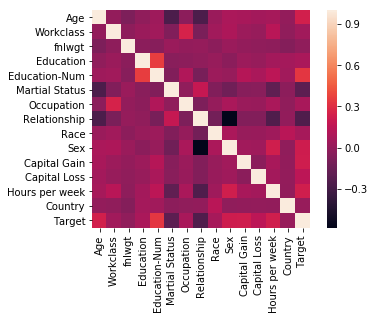

In [19]:
from sklearn import preprocessing
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #print(result[column])
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(original_data)
sns.heatmap(encoded_data.corr(), square=True)
plt.savefig('./figure/corr.png',dpi=600)
plt.show()


In [20]:
original_data[["Education", "Education-Num"]].head(15)


,Education,Education-Num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


In [23]:
#del original_data["Education"]


In [24]:
original_data[["Sex", "Relationship"]].head(15)


,Sex,Relationship
0,Male,Not-in-family
1,Male,Husband
2,Male,Not-in-family
3,Male,Husband
4,Female,Wife
5,Female,Wife
6,Female,Not-in-family
7,Male,Husband
8,Female,Not-in-family
9,Male,Husband


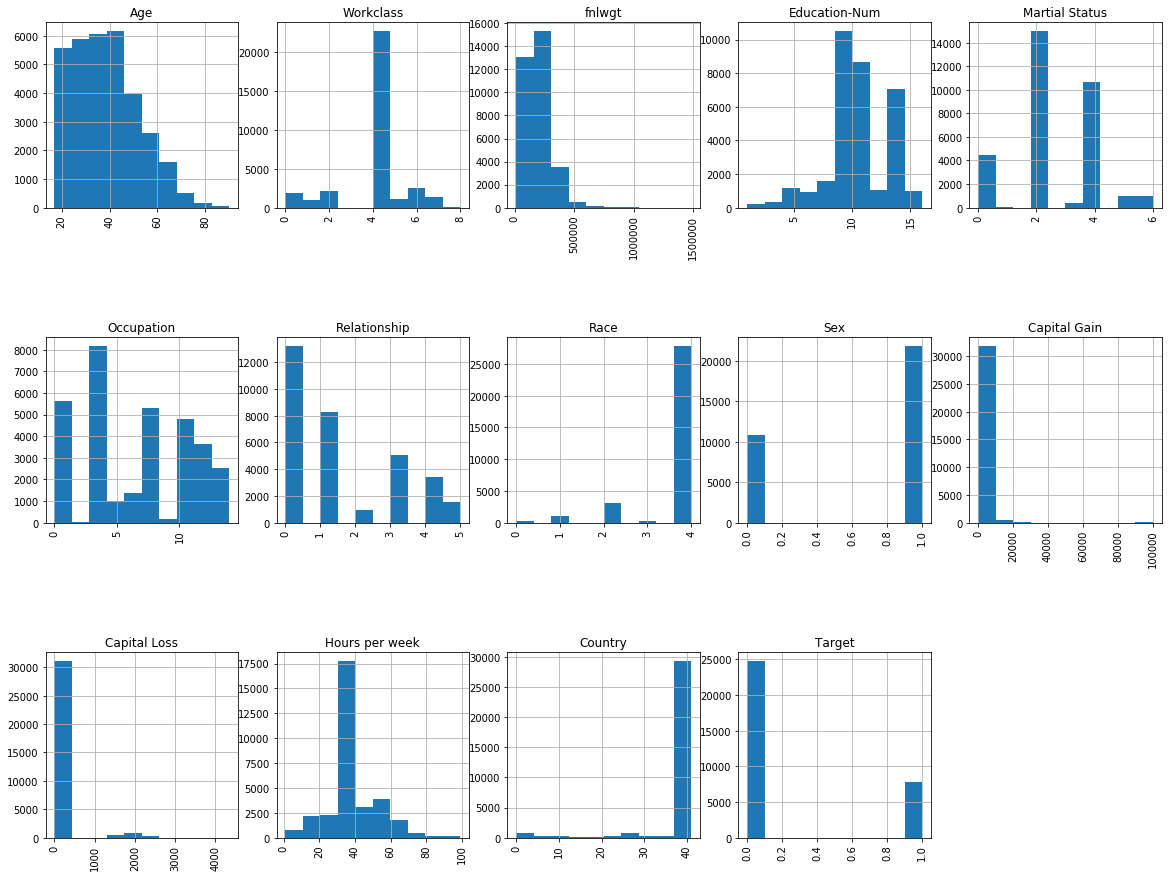

In [25]:
encoded_data, encoders = number_encode_features(original_data)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = np.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [26]:
print(len(encoded_data.columns))

14


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_data[encoded_data.columns[:len(encoded_data.columns)-1]], 
    encoded_data["Target"], train_size=0.70)

scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype('float64')), columns=X_train.columns)
X_test = scaler.transform(X_test.astype('float64'))

C:\Users\xiahaa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 score: 0.569620


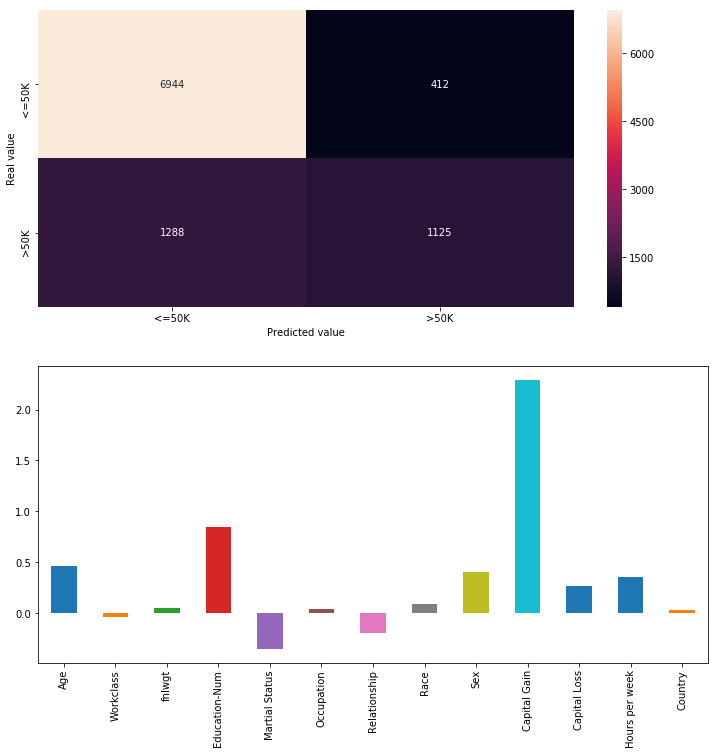

In [28]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=encoders["Target"].classes_, 
            yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print('F1 score: %f'% skl.metrics.f1_score(y_test, y_pred))
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs.sort_values()
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

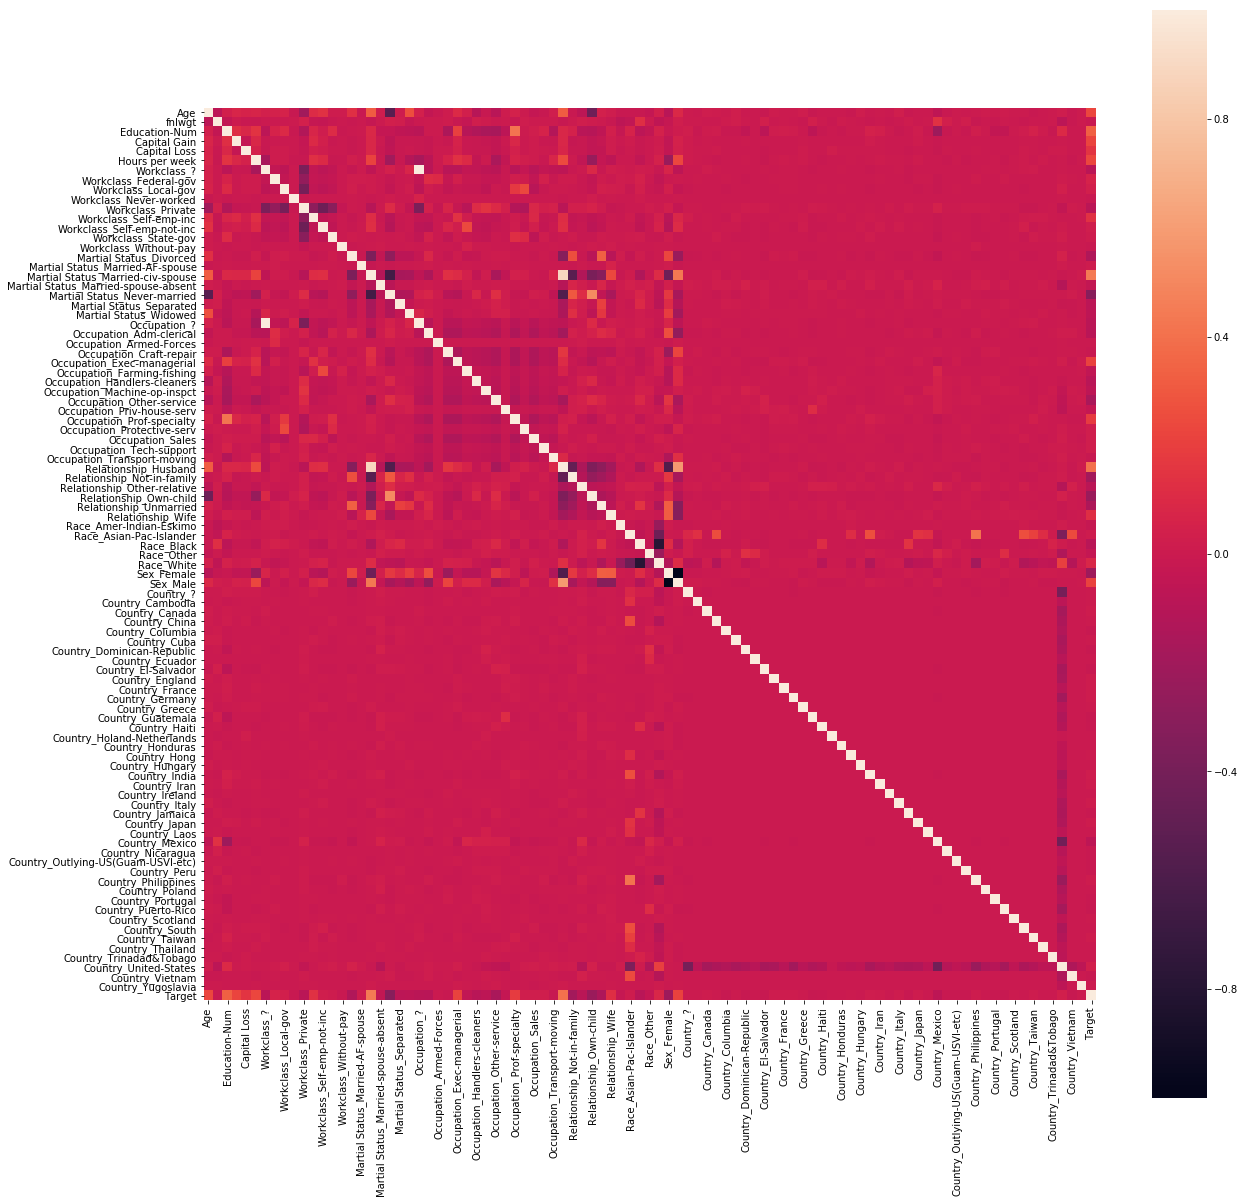

In [29]:
binary_data = pd.get_dummies(original_data)
# Let's fix the Target as it will be converted to dummy vars too
binary_data["Target"] = binary_data["Target_>50K"]
del binary_data["Target_<=50K"]
del binary_data["Target_>50K"]
plt.subplots(figsize=(20,20))
sns.heatmap(binary_data.corr(), square=True)
plt.show()

In [30]:
idsel = binary_data.columns != 'Target'
X_train, X_test, y_train, y_test = train_test_split(
    binary_data[binary_data.columns[idsel]], 
    binary_data["Target"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)